In [267]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tqdm import tqdm_notebook

In [268]:
#Tensorflow Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

In [269]:
#Uploading data
dataset_path = "chest_ray"
train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

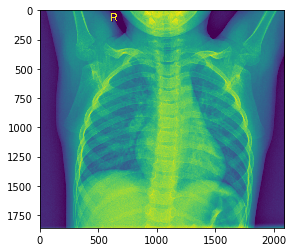

In [270]:
# An example in the training set
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

In [271]:
'''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + '/'+ subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)

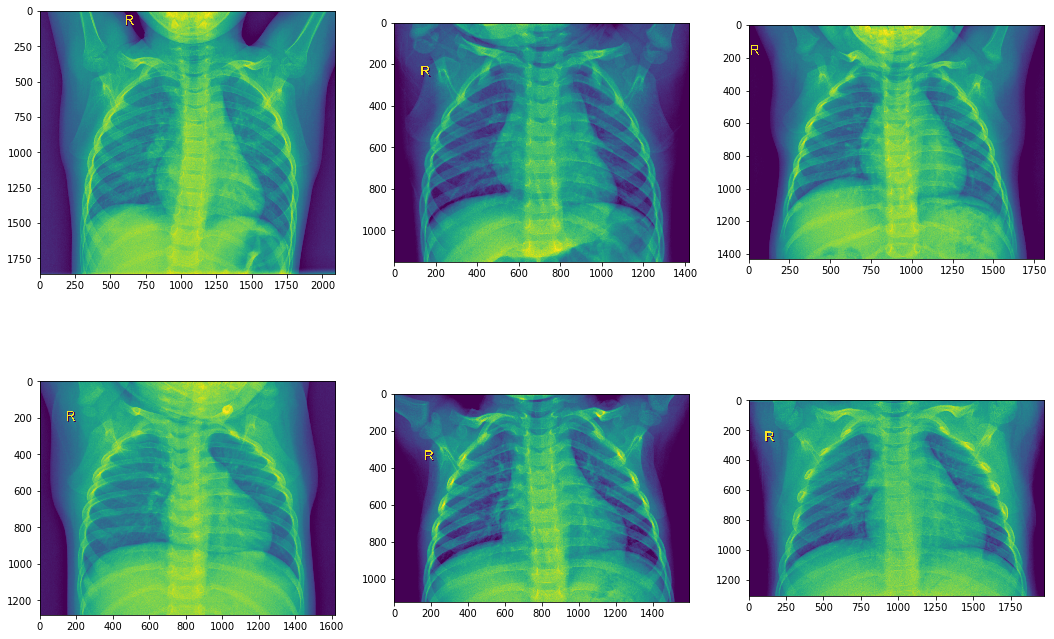

In [272]:
#Looking at normal cases
plot_img("train", "NORMAL")

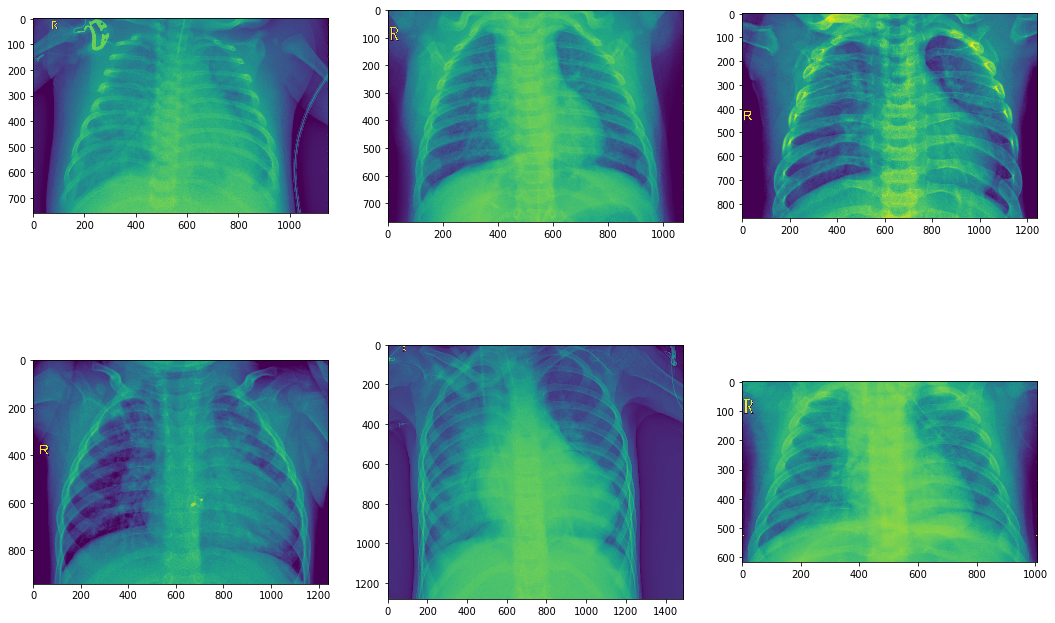

In [273]:
#Looking at cases with pneumonia 
plot_img("train", "PNEUMONIA")

In [274]:
def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

In [275]:
#building the model
IMG_SHAPE = (150, 150, 3)
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")
base_model.summary() # This is quite a complex architecture


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [276]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer

<tf.Tensor 'global_average_pooling2d_2/Mean:0' shape=(?, 2048) dtype=float32>

In [277]:

global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

In [278]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

Total params: 23,016,354
Trainable params: 22,981,922
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [279]:
#Compiling the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [280]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [281]:
#Generating time
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical")
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=128, class_mode="categorical")
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [282]:
#Fitting the model
model.fit_generator(train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
41/41 [==============================] - 1631s 40s/step - loss: 0.2158 - acc: 0.9049 - val_loss: 7.5827 - val_acc: 0.5000
Epoch 2/5
41/41 [==============================] - 1635s 40s/step - loss: 0.0372 - acc: 0.9873 - val_loss: 7.5095 - val_acc: 0.5000
Epoch 3/5
41/41 [==============================] - 1664s 41s/step - loss: 0.0161 - acc: 0.9941 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
41/41 [==============================] - 1715s 42s/step - loss: 0.0085 - acc: 0.9981 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
41/41 [==============================] - 1709s 42s/step - loss: 0.0102 - acc: 0.9977 - val_loss: 8.0590 - val_acc: 0.5000


In [283]:
#Evaluation time
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.5


In [284]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

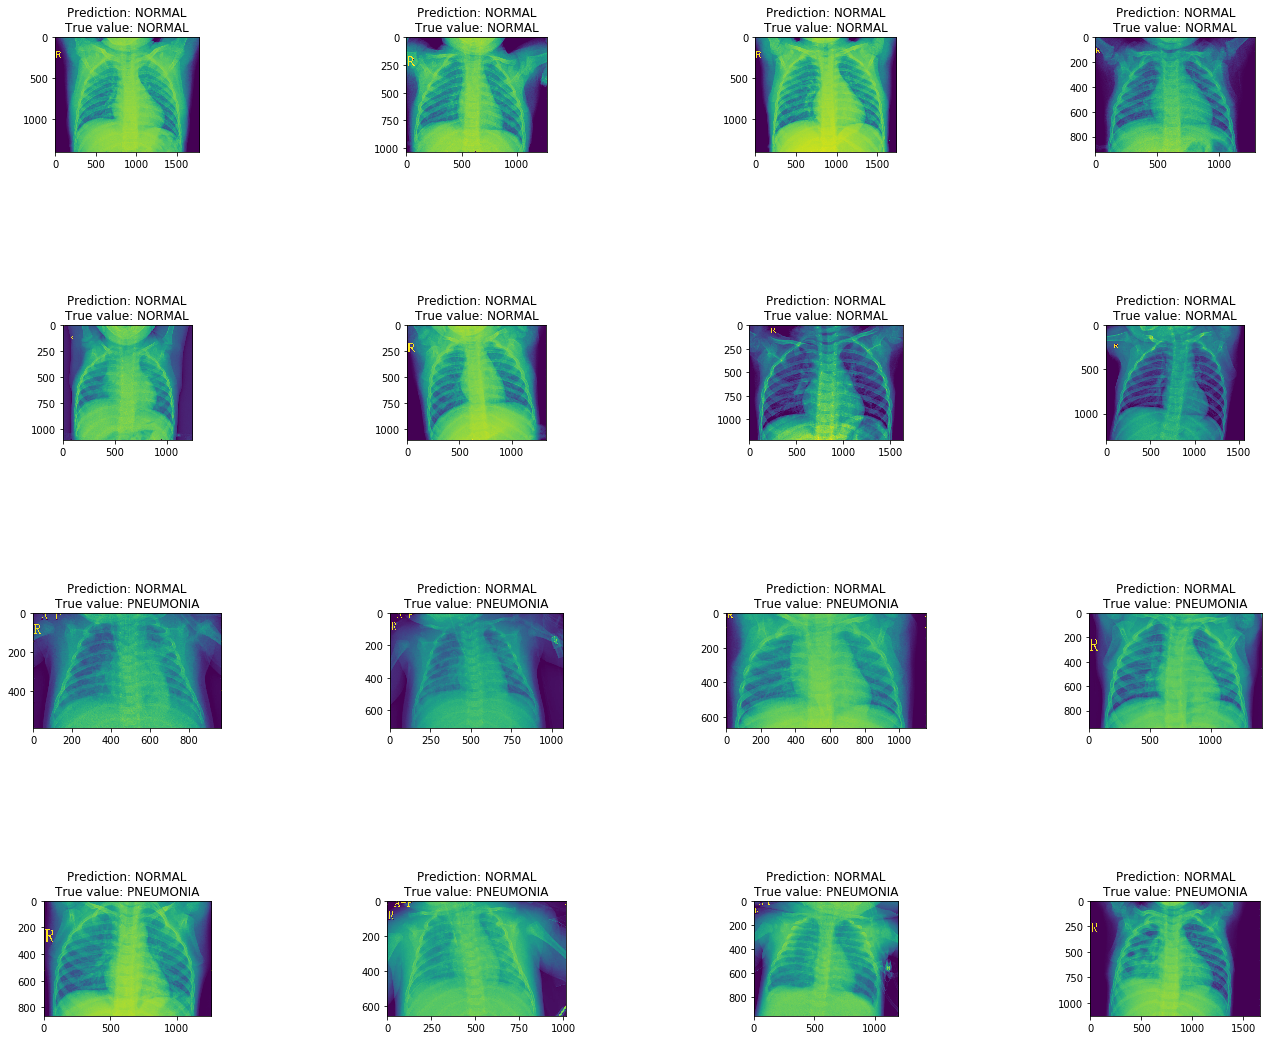

In [285]:
compare_results(validation_dir, valid_generator)

In [286]:
#Save the model in current directory
import json
# serialize model to JSON
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [287]:
#Time to improve the model
base_model.trainable = True
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 311


In [288]:
# Defining the unfreezing starting point
fine_tune_at = 200

In [289]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [290]:
#Comparing and fitting the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit_generator(generator = train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
41/41 [==============================] - 694s 17s/step - loss: 0.0019 - acc: 0.9992 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
41/41 [==============================] - 641s 16s/step - loss: 0.0054 - acc: 0.9987 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
41/41 [==============================] - 780s 19s/step - loss: 0.0010 - acc: 0.9996 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
41/41 [==============================] - 771s 19s/step - loss: 5.1556e-04 - acc: 0.9998 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
41/41 [==============================] - 717s 17s/step - loss: 3.6048e-05 - acc: 1.0000 - val_loss: 8.0590 - val_acc: 0.5000


In [291]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.5


In [292]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

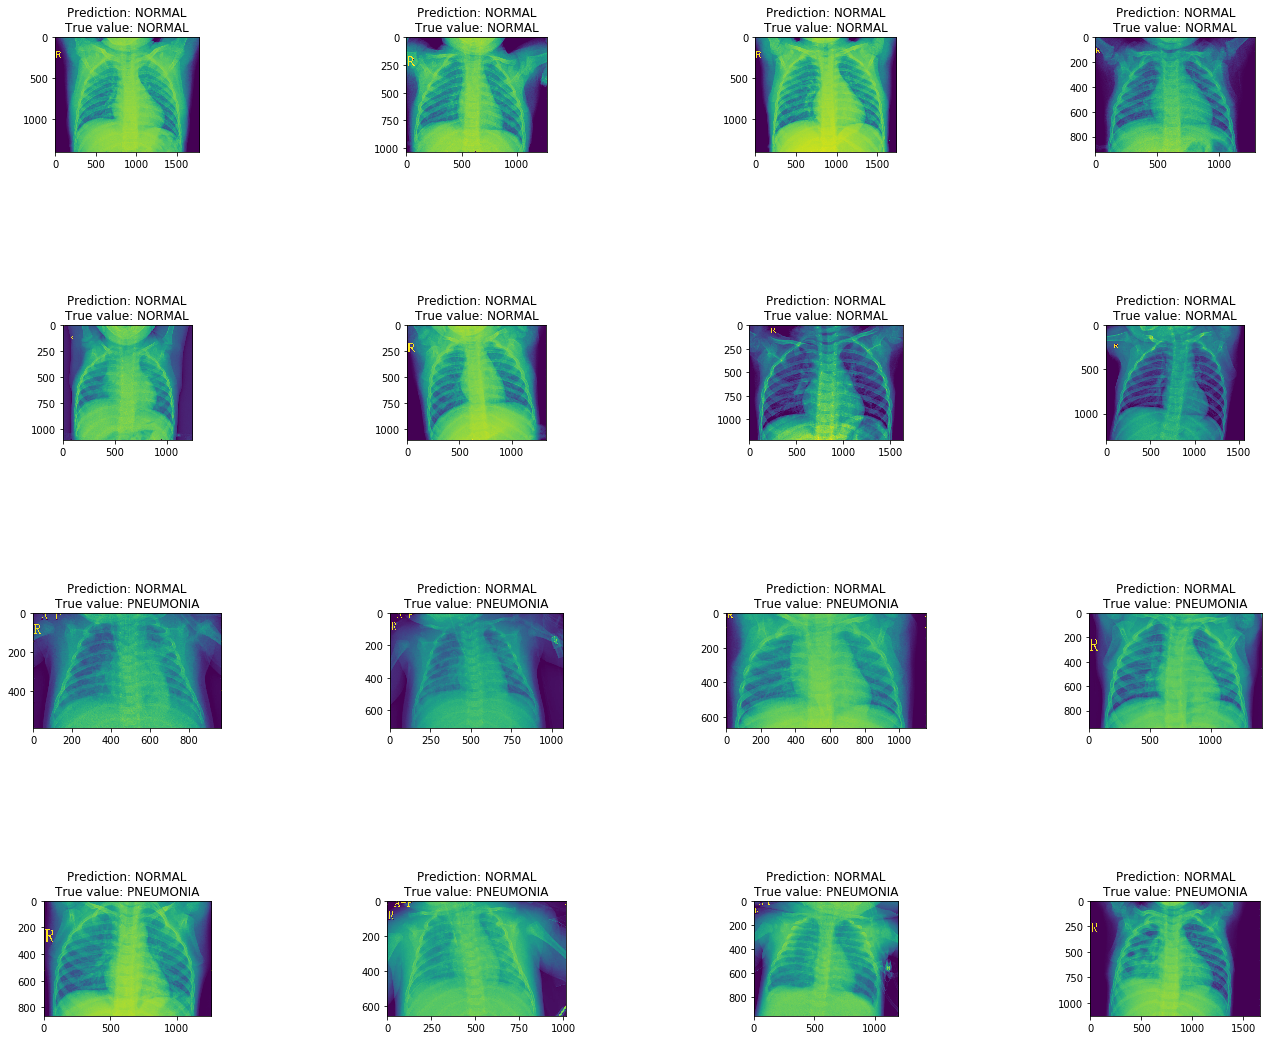

In [294]:
#Plotting new results
compare_results(validation_dir, valid_generator)